# Classification. Linear models and KNN

In [127]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [129]:
PATH = "./data/"


In [130]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
train_df = data.copy()
test_df = test.copy()
combine = [train_df, test_df]

In [131]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [132]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [133]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [134]:
count=data[['Sex','Survived']].value_counts()
count

Sex     Survived
male    0           468
female  1           233
male    1           109
female  0            81
dtype: int64

In [135]:
print('Соотношение выживших мужчин, к количеству мужчин: ',count[2]/(count[0]+count[2]))
print('Соотношение выживших женщин, к количеству женщин: ',count[1]/(count[3]+count[1]))

Соотношение выживших мужчин, к количеству мужчин:  0.18890814558058924
Соотношение выживших женщин, к количеству женщин:  0.7420382165605095


In [136]:
encoder = OneHotEncoder()
test['Fare']=test['Fare'].fillna(test['Fare'].mean())
data['Embarked']=data['Embarked'].fillna('S')
encoded_X = encoder.fit_transform(data[['Sex','Embarked']]).toarray()
encod=pd.DataFrame(encoded_X, columns=encoder.get_feature_names(),index=range(1,len(encoded_X)+1))
data = pd.concat([data,encod[['x0_female','x0_male','x1_C','x1_Q','x1_S']]],axis = 1)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,x0_female,x0_male,x1_C,x1_Q,x1_S
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,1.0,0.0,0.0,1.0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0.0,0.0,0.0,1.0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1.0,0.0,0.0,0.0,1.0
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0,1.0,1.0,0.0,0.0


In [137]:
encoded_X = encoder.fit_transform(test[['Sex','Embarked']]).toarray()
encod=pd.DataFrame(encoded_X, columns=encoder.get_feature_names(),index=range(892,len(encoded_X)+892))
test = pd.concat([test,encod[['x0_female','x0_male','x1_C','x1_Q','x1_S']]],axis = 1)
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,x0_female,x0_male,x1_C,x1_Q,x1_S
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0,1.0,0.0,1.0,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0,0.0,0.0,0.0,1.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0,1.0,0.0,1.0,0.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0,1.0,0.0,0.0,1.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1.0,0.0,1.0,0.0,0.0
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0


In [138]:
#data['Embarked_int']=data['x0_male']
#data['Embarked_int']=data['x1_C']*1+data['x1_Q']*2+data['x1_S']*3
data.corr(method='pearson')

,Survived,Pclass,Age,SibSp,Parch,Fare,x0_female,x0_male,x1_C,x1_Q,x1_S
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.074053
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,0.036261,-0.022405,-0.023233
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.068734
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.060814
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.162184
x0_female,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.119224
x0_male,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.119224
x1_C,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.782742
x1_Q,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,0.074115,-0.074115,-0.148258,1.000000,-0.499421


Как мы видим из данных, что женщин выжило намного больше: 75% женщин и 19% мужчин выжило, хотя женщин меньше: количество женщин 314, количество мужчин 577. И корреляция между полом и виживаемостью равна 0.54. И отсюдо можно сделать вывод, что взаимосвязь между выживаемостью и полом есть.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

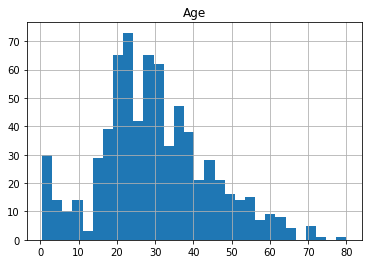

График возраста всех пассажиров


In [139]:
data.hist(column='Age', bins=30)
plt.show()
print('График возраста всех пассажиров')

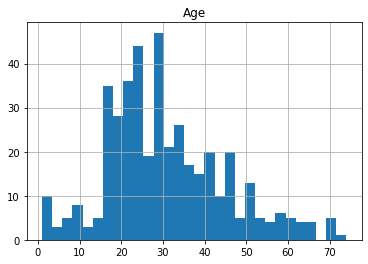

График возраста не выживших пассажиров


In [140]:
data[data['Survived']==0].hist(column='Age', bins=30)
plt.show()
print('График возраста не выживших пассажиров')

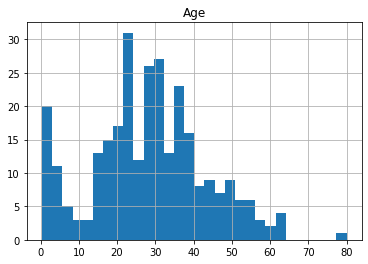

График возраста выживших пассажиров


In [141]:
data[data['Survived']==1].hist(column='Age', bins=30)
plt.show()
print('График возраста выживших пассажиров')

In [142]:
print('Средний возраст пассажиров на титанике: ',data['Age'].mean(),'\nСредний возраст выживших: ',data[data['Survived']==1]['Age'].mean(),'\nСредний возраст не выживших: ',data[data['Survived']==0]['Age'].mean())

Средний возраст пассажиров на титанике:  29.69911764705882 
Средний возраст выживших:  28.343689655172415 
Средний возраст не выживших:  30.62617924528302


Как мы видим из данных выжили на титанике более молодые люди, хотя разница не значительная. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [143]:
count=data[['Embarked','Survived']].value_counts()
count

Embarked  Survived
S         0           427
          1           219
C         1            93
          0            75
Q         0            47
          1            30
dtype: int64

In [144]:
print('Соотношение выживших людей севших в Southampton, к количеству людей севших в Southampton: ',count[1]/(count[0]+count[1]))
print('Соотношение выживших людей севших в Cherbourg, к количеству людей севших в Cherbourg: ',count[2]/(count[3]+count[2]))
print('Соотношение выживших людей севших в Queenstown, к количеству людей севших в Queenstown: ',count[5]/(count[4]+count[5]))

Соотношение выживших людей севших в Southampton, к количеству людей севших в Southampton:  0.33900928792569657
Соотношение выживших людей севших в Cherbourg, к количеству людей севших в Cherbourg:  0.5535714285714286
Соотношение выживших людей севших в Queenstown, к количеству людей севших в Queenstown:  0.38961038961038963


In [145]:
count=data[['Embarked','Pclass']].value_counts()
count

Embarked  Pclass
S         3         353
          2         164
          1         129
C         1          85
Q         3          72
C         3          66
          2          17
Q         2           3
          1           2
dtype: int64

In [146]:
print('Соотношение людей севших в Southampton 1 классом, к количеству людей севших в Southampton: ',count['S'][1]/count['S'].sum())
print('Соотношение людей севших в Cherbourg 1 классом, к количеству людей севших в Cherbourg: ',count['C'][1]/count['C'].sum())
print('Соотношение людей севших в Queenstown 1 классом, к количеству людей севших в Queenstown: ',count['Q'][1]/count['Q'].sum())
print('Соотношение людей севших в Southampton 2 классом, к количеству людей севших в Southampton: ',count['S'][2]/count['S'].sum())
print('Соотношение людей севших в Cherbourg 2 классом, к количеству людей севших в Cherbourg: ',count['C'][2]/count['C'].sum())
print('Соотношение людей севших в Queenstown 2 классом, к количеству людей севших в Queenstown: ',count['Q'][2]/count['Q'].sum())

Соотношение людей севших в Southampton 1 классом, к количеству людей севших в Southampton:  0.1996904024767802
Соотношение людей севших в Cherbourg 1 классом, к количеству людей севших в Cherbourg:  0.5059523809523809
Соотношение людей севших в Queenstown 1 классом, к количеству людей севших в Queenstown:  0.025974025974025976
Соотношение людей севших в Southampton 2 классом, к количеству людей севших в Southampton:  0.25386996904024767
Соотношение людей севших в Cherbourg 2 классом, к количеству людей севших в Cherbourg:  0.10119047619047619
Соотношение людей севших в Queenstown 2 классом, к количеству людей севших в Queenstown:  0.03896103896103896


In [147]:
count=data[['Pclass','Survived']].value_counts()
count

Pclass  Survived
3       0           372
1       1           136
3       1           119
2       0            97
        1            87
1       0            80
dtype: int64

In [148]:
print('Соотношение выживших в 3 классе, к количеству людей в 3 классе: ',count[3][1]/count[3].sum())
print('Соотношение выживших во 2 классе, к количеству людей в 2 классе: ',count[2][1]/count[2].sum())
print('Соотношение выживших в 1 классе, к количеству людей в 1 классе: ',count[1][1]/count[1].sum())

Соотношение выживших в 3 классе, к количеству людей в 3 классе:  0.24236252545824846
Соотношение выживших во 2 классе, к количеству людей в 2 классе:  0.47282608695652173
Соотношение выживших в 1 классе, к количеству людей в 1 классе:  0.6296296296296297


Самый безопасный класс 1, а самый небезопасный 3, это мы видим из соотношения.
Отношение между портом и выживаемостью косвенная, так как тут отражается связь между классом и выживаемостью, так как в ращных портах содилось разное соотношение людей с 1 классом и из-за этого соотношение выжившиз в Cherbourg больше чем у других, так как соотношение севших людей в 1 классе намного больше, чем в других портах.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [149]:
data.isnull().mean()

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age          0.198653
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin        0.771044
Embarked     0.000000
x0_female    0.000000
x0_male      0.000000
x1_C         0.000000
x1_Q         0.000000
x1_S         0.000000
dtype: float64

In [150]:
test.isnull().mean()

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age          0.205742
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin        0.782297
Embarked     0.000000
x0_female    0.000000
x0_male      0.000000
x1_C         0.000000
x1_Q         0.000000
x1_S         0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Я предлагаю исключить колонку Cabin. В этом случае слишком много пустых значениях.А возраст можно заполнить, составив модель предсказания, которая передсказывает возраст.

In [151]:
main_model = LogisticRegression(solver='liblinear', penalty='l1')
data_learn = data[~data['Age'].isnull()]
data_test = data[data['Age'].isnull()]
test_test = test[test['Age'].isnull()]
columns=['Survived','Pclass','SibSp','Parch','Fare','x0_female','x0_male','x1_C','x1_Q','x1_S']
main_model.fit(data_learn[columns],data_learn['Age'].astype('int'))
print('Result {:f}'.format(cross_val_score(main_model, data_learn[columns], data_learn['Age'].astype('int'), scoring='accuracy', cv=5).mean()))


c:\Users\BogAk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Result 0.046233


In [152]:
data_test['Age']=main_model.predict(data_test[columns])
columns=['Pclass','SibSp','Parch','Fare','x0_female','x0_male','x1_C','x1_Q','x1_S']
main_model.fit(data_learn[columns],data_learn['Age'].astype('int'))
test_test['Age']=main_model.predict(test_test[columns])

<ipython-input-152-f92e111b0f3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Age']=main_model.predict(data_test[columns])
<ipython-input-152-f92e111b0f3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_test['Age']=main_model.predict(test_test[columns])


In [153]:
data['Age']=data['Age'].fillna(data_test['Age'])
test['Age']=test['Age'].fillna(test_test['Age'])

In [154]:
test.isnull().mean()

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin        0.782297
Embarked     0.000000
x0_female    0.000000
x0_male      0.000000
x1_C         0.000000
x1_Q         0.000000
x1_S         0.000000
dtype: float64

In [155]:
data.isnull().mean()

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin        0.771044
Embarked     0.000000
x0_female    0.000000
x0_male      0.000000
x1_C         0.000000
x1_Q         0.000000
x1_S         0.000000
dtype: float64

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [156]:
y = data['Survived']

In [157]:
columns=['Pclass','SibSp','Parch','Fare','x0_female','x0_male','x1_C','x1_Q','x1_S','Age']
knn = KNeighborsClassifier(n_neighbors=3)
main_model = LogisticRegression()
main_model.fit(data[columns],data['Survived'])
knn.fit(data[columns],data['Survived'])
print('Result {:f}'.format(cross_val_score(main_model, StandardScaler().fit_transform(data[columns]), data['Survived'], scoring='accuracy', cv=5).mean()))
print('Result {:f}'.format(cross_val_score(knn, StandardScaler().fit_transform(data[columns]), data['Survived'], scoring='accuracy', cv=5).mean()))


Result 0.793491
Result 0.805838


c:\Users\BogAk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [158]:
main_model.fit(data[columns],data['Survived'])
knn.fit(data[columns],data['Survived'])
pred=knn.predict(test[columns])
a=892
for i in range(len(pred)):
    print(a,',',pred[i])
    a+=1


c:\Users\BogAk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


892 , 0
893 , 0
894 , 1
895 , 1
896 , 0
897 , 0
898 , 1
899 , 1
900 , 0
901 , 0
902 , 0
903 , 0
904 , 1
905 , 0
906 , 0
907 , 1
908 , 0
909 , 0
910 , 1
911 , 0
912 , 0
913 , 0
914 , 0
915 , 1
916 , 1
917 , 0
918 , 1
919 , 0
920 , 0
921 , 1
922 , 1
923 , 1
924 , 1
925 , 0
926 , 1
927 , 0
928 , 1
929 , 1
930 , 0
931 , 1
932 , 0
933 , 0
934 , 0
935 , 1
936 , 1
937 , 0
938 , 0
939 , 0
940 , 1
941 , 0
942 , 1
943 , 0
944 , 0
945 , 1
946 , 0
947 , 0
948 , 0
949 , 0
950 , 0
951 , 1
952 , 0
953 , 1
954 , 0
955 , 1
956 , 1
957 , 1
958 , 0
959 , 0
960 , 0
961 , 1
962 , 0
963 , 0
964 , 0
965 , 0
966 , 1
967 , 0
968 , 0
969 , 0
970 , 0
971 , 0
972 , 1
973 , 1
974 , 1
975 , 0
976 , 0
977 , 0
978 , 1
979 , 0
980 , 1
981 , 1
982 , 0
983 , 0
984 , 1
985 , 0
986 , 1
987 , 0
988 , 1
989 , 0
990 , 1
991 , 0
992 , 1
993 , 1
994 , 0
995 , 0
996 , 1
997 , 0
998 , 0
999 , 0
1000 , 0
1001 , 0
1002 , 1
1003 , 1
1004 , 1
1005 , 1
1006 , 1
1007 , 0
1008 , 0
1009 , 1
1010 , 1
1011 , 1
1012 , 0
1013 , 0
1014 , 1
1

In [159]:
pd.cut(train_df['Age'], 5)

PassengerId
1      (16.336, 32.252]
2      (32.252, 48.168]
3      (16.336, 32.252]
4      (32.252, 48.168]
5      (32.252, 48.168]
             ...       
887    (16.336, 32.252]
888    (16.336, 32.252]
889                 NaN
890    (16.336, 32.252]
891    (16.336, 32.252]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

In [160]:
pd.qcut(train_df['Fare'], 4)

PassengerId
1       (-0.001, 7.91]
2      (31.0, 512.329]
3       (7.91, 14.454]
4      (31.0, 512.329]
5       (7.91, 14.454]
            ...       
887     (7.91, 14.454]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (14.454, 31.0]
891     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [161]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','Rare'], 5)
    dataset['Title'] = dataset['Title'].replace(['Ms','Mlle','Miss'], 2)
    dataset['Title'] = dataset['Title'].replace(['Mme','Mrs'], 3)
    dataset['Title'] = dataset['Title'].replace('Mr', 1)
    dataset['Title'] = dataset['Title'].replace('Master', 4)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    guess_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
#train_df = train_df.drop(['Name','Ticket', 'Cabin'], axis=1)
#test_df = test_df.drop(['Name','Ticket', 'Cabin'], axis=1)
train_df = train_df.drop(['Name','Parch', 'SibSp', 'FamilySize','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name','Parch', 'SibSp', 'FamilySize','Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [162]:
test_df

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
PassengerId,,,,,,,,
892,3,0,2,0,2,1,1,6
893,3,1,2,0,0,3,0,6
894,2,0,3,1,2,1,1,6
895,3,0,1,1,0,1,1,3
896,3,1,1,1,0,3,0,3
...,...,...,...,...,...,...,...,...
1305,3,0,1,1,0,1,1,3
1306,1,1,2,3,1,5,1,2
1307,3,0,2,0,0,1,1,6


In [163]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_df.drop("Survived", axis=1), train_df["Survived"])
pred = knn.predict(test_df)
acc_knn = round(knn.score(train_df.drop("Survived", axis=1), train_df["Survived"]) * 100, 2)
acc_knn
main_model.fit(train_df.drop("Survived", axis=1), train_df["Survived"])
#pred=main_model.predict(test_df)

LogisticRegression()

In [164]:
#main_model.fit(data[columns],data['Survived'])
#knn.fit(data[columns],data['Survived'])
#pred=knn.predict(test[columns])
a=892
for i in range(len(pred)):
    print(a,',',pred[i])
    a+=1

892 , 0
893 , 0
894 , 0
895 , 0
896 , 0
897 , 0
898 , 1
899 , 0
900 , 1
901 , 0
902 , 0
903 , 0
904 , 1
905 , 0
906 , 1
907 , 1
908 , 0
909 , 0
910 , 0
911 , 0
912 , 0
913 , 1
914 , 1
915 , 1
916 , 1
917 , 0
918 , 1
919 , 0
920 , 0
921 , 0
922 , 0
923 , 0
924 , 0
925 , 1
926 , 1
927 , 0
928 , 0
929 , 0
930 , 0
931 , 1
932 , 0
933 , 0
934 , 0
935 , 1
936 , 1
937 , 0
938 , 0
939 , 0
940 , 1
941 , 0
942 , 0
943 , 0
944 , 1
945 , 1
946 , 0
947 , 0
948 , 0
949 , 0
950 , 0
951 , 1
952 , 0
953 , 0
954 , 0
955 , 1
956 , 1
957 , 1
958 , 1
959 , 0
960 , 1
961 , 1
962 , 1
963 , 0
964 , 0
965 , 1
966 , 1
967 , 0
968 , 0
969 , 1
970 , 0
971 , 1
972 , 1
973 , 0
974 , 0
975 , 0
976 , 0
977 , 0
978 , 1
979 , 0
980 , 1
981 , 1
982 , 0
983 , 0
984 , 1
985 , 0
986 , 1
987 , 0
988 , 1
989 , 0
990 , 0
991 , 0
992 , 1
993 , 0
994 , 0
995 , 0
996 , 1
997 , 0
998 , 0
999 , 0
1000 , 0
1001 , 0
1002 , 0
1003 , 1
1004 , 1
1005 , 1
1006 , 1
1007 , 0
1008 , 0
1009 , 0
1010 , 0
1011 , 1
1012 , 1
1013 , 0
1014 , 1
1

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Мой скор на  kaggle 0.77990, ник Akim Bogodiazh https://www.kaggle.com/bogodakim. Надеюсь вы округлите его до 78 :)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [165]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
train_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
test_data = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [166]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [167]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [168]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [169]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [170]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [171]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

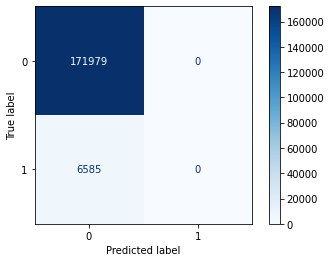

In [172]:
disp = plot_confusion_matrix(clf, X_valid, y_valid, cmap=plt.cm.Blues, normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [173]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

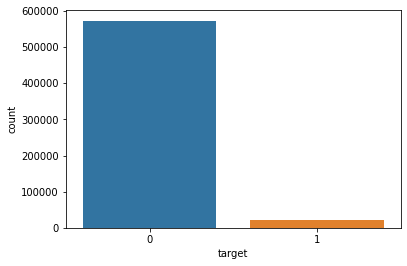

In [174]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [175]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

I had the same thoughts and I stumbled upon a nice presentation.

Let us use the following definitions:

Gini (mostly equal to the accuracy ratio "AR") is the ratio of the area between your curve and the diagonal and the area between the perfect model and the diagonal. This definition on the CAP curve gives the usual Gini. If you use it on the ROC curve then you see the relation to the AUC. The perfect model in the ROC is just a straight line (0% FPR and 100% TPR).


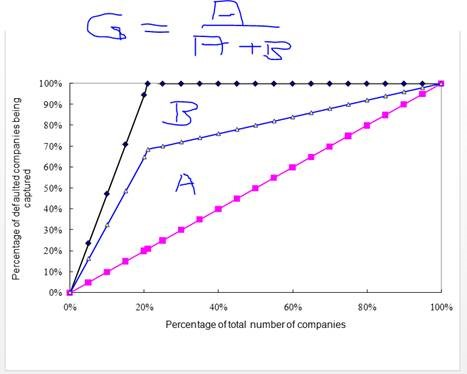

In [176]:
Image("1qkC7.jpg") 


I tried to make this clear in the following two plots.

First on the CAP you get Gini by the usual formula:

Then on the ROC you see the perfect model and apply the same formual. We use that the area between the perfect model and the diagonal is 1/2 in this case:

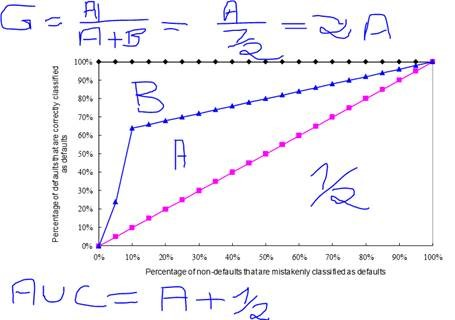

In [177]:
Image("4Kk2a.jpg") 



Finally, using that A=G/2 we get the relationship: G=2⋅AUC−1.

Вот еще объяснение на русском, но болле  математически сложное https://habr.com/ru/company/ods/blog/350440/

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

F-Measure (FM) - F-мера представляет гармоническое среднее между точностью и полнотой, позволяя оптимизировать сразу две эти метрики.
Geometric-mean (GM) - Геометрическое среднее используется для максимизации верно-положительных и верно-отрицательных классификаций, при этом сохраняя баланс между ними.

Let's calculate the Normalized Gini Coefficient:

In [178]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [179]:
gini_normalized(y_valid, y_pred)

<ipython-input-175-7fd68ac4b908>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)


0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [180]:
rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1000, max_leaf_nodes=100, n_jobs=-1)
rf.fit(X, y)
predicted_score1 = rf.predict_proba(test_data)

In [181]:
result = pd.DataFrame({'id': test_data.index, 'target': predicted_score1[:,1]})
result.to_csv('answer_porto.csv', index=False)

In [182]:
print('My score: 0.5 points +',round(200*(0.26297-0.253))/2, 'bonus points')

My score: 0.5 points + 1.0 bonus points


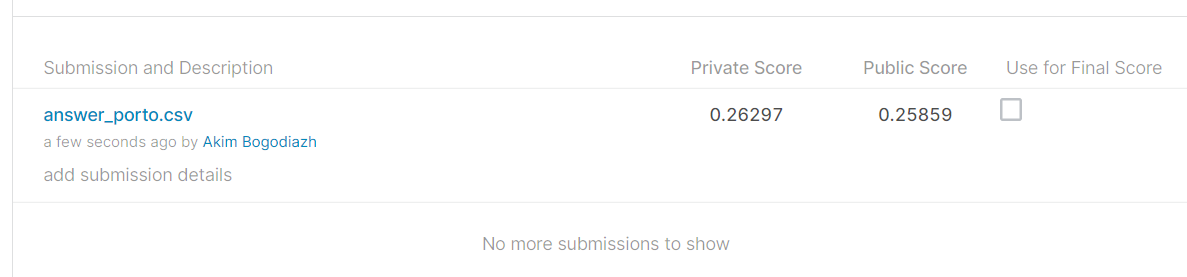

In [183]:
Image("result.png")